# Data description & Problem statement: 
The dataset here is a sample of the transactions made in a retail store. The store wants to know better the customer purchase behaviour against different products. Specifically, here the problem is a Regression problem where we are trying to predict the dependent variable (the amount of purchase) with the help of the information contained in the other variables. The data set has 550067 rows and 11 variables.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial RF model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of RF model: Find the best RF model
   # Model Evaluation: 
- Evaluate the best RF model with optimized hyperparameters on Test Dataset, by calculating:
     - r2 (determination factor)
     - Lift chart
     - RMSE 
     - Box-plot for prediction Vs. actual values 
     - Distribution plot of error/residuals
     
Finally, calculate the Feature Importance for the features 

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('train.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [3]:
df.drop(['Product_Category_3' ], axis=1, inplace=True)

#Replace missing values with -999
df.fillna(999, inplace=True)

In [4]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# for i in ['User_ID', 'Product_ID', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years']:
for i in ['User_ID', 'Product_ID', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years',
          'Gender', 'Marital_Status', 'Product_Category_1', 'Product_Category_2' ]:
    encode_text_index(df, i)

In [5]:
X=df.drop(['Purchase'], axis=1)
y=df['Purchase']

# Re-scaling & Polynomial Interactions:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)

scaler_y=MinMaxScaler().fit(pd.DataFrame(y))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

In [6]:
# We build the Initial Model:
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(max_features=9, n_estimators=50, max_depth=20, random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
from math import sqrt

pred=model.predict(X_test)

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(y_test_inv, pred_inv))
print('Test rmse: ', rmse)

Test rmse:  2718.9353894435685


In [7]:
# Grid-Serach for the best model parameters: 
from sklearn.model_selection import GridSearchCV

param={'max_depth':[24, 32], 'max_features':[6, 8], 'n_estimators': [300]}

grid_search=GridSearchCV(RandomForestRegressor(oob_score=True, random_state=42), param, cv=2, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [24, 32], 'max_features': [4, 8], 'n_estimators': [300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [8]:
G=pd.DataFrame(grid_search.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,436.914235,0.017256,42.569319,0.009601,24,4,300,"{'max_depth': 24, 'max_features': 4, 'n_estima...",0.705667,0.707621,0.706644,0.000977,1,0.924923,0.924297,0.924610,3.129836e-04
1,623.953733,0.048055,43.027931,0.093728,24,8,300,"{'max_depth': 24, 'max_features': 8, 'n_estima...",0.705380,0.706994,0.706187,0.000807,2,0.930303,0.929910,0.930106,1.967652e-04
2,333.028172,0.359294,64.572005,7.052687,32,4,300,"{'max_depth': 32, 'max_features': 4, 'n_estima...",0.704443,0.705835,0.705139,0.000696,3,0.956378,0.956376,0.956377,7.495369e-07


In [9]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'max_depth': 24, 'max_features': 4, 'n_estimators': 300}
Best validation accuracy:  0.71 (+/- 0.00)
Test score:  0.71


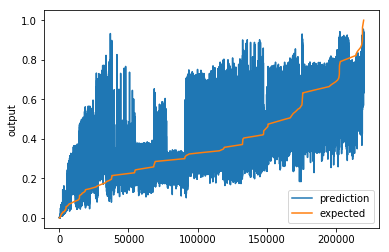

In [10]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(y, pred, sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(),label='prediction')
    a = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=grid_search.predict(X_test)
chart_regression(np.array(y_test), pred.flatten(), sort=True)

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(y_test_inv, pred_inv))
print('Test RMSE: ', rmse)

Test RMSE:  2694.6956575372515


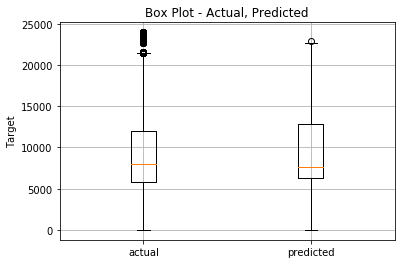

In [12]:
plt.boxplot([y_test_inv.ravel(), pred_inv.ravel()], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

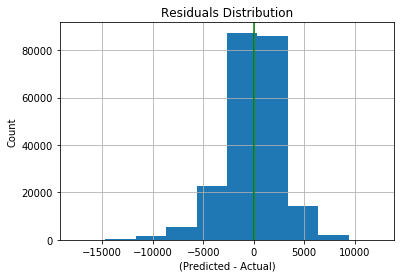

In [13]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test_inv.ravel()-pred_inv.ravel()

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()

('Product_Category_1', 0.5715007818616546)
('Product_ID', 0.14591664551426622)
('Product_Category_2', 0.0987342031079519)
('User_ID', 0.07582530338146201)
('Occupation', 0.036393251360474006)
('Stay_In_Current_City_Years', 0.023637091010691082)
('Age', 0.02188776660586781)
('City_Category', 0.01061844745605571)
('Marital_Status', 0.008683455210731219)
('Gender', 0.00680305449084524)


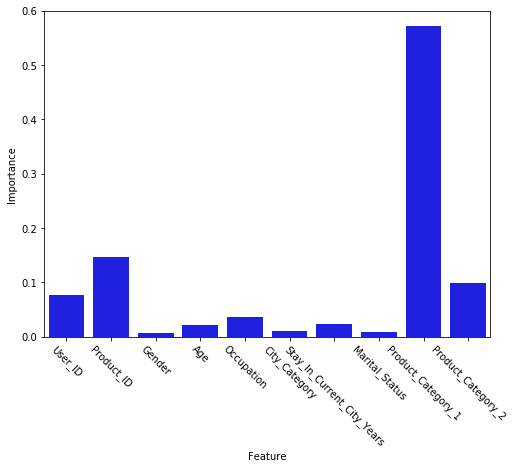

In [14]:
# Feature Importance:
im=RandomForestRegressor( max_depth= 24, max_features= 4, n_estimators= 300, random_state=42).fit(X,y).feature_importances_

# Sort & Plot:
d=dict(zip(X.columns, im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(X.columns, columns=["Feature"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=-45)
plt.show()